In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

## Read in the Data

In [2]:
train_df = pd.read_csv('training.csv')
train_df.head()

,InPlay,Velo,SpinRate,HorzBreak,InducedVertBreak
0,0,95.33,2893.0,10.68,21.33
1,0,94.41,2038.0,17.13,5.77
2,0,90.48,2183.0,6.61,15.39
3,0,93.04,2279.0,9.33,14.57
4,0,95.17,2384.0,6.99,17.62


In [3]:
train_df.isnull().sum()

InPlay              0
Velo                0
SpinRate            6
HorzBreak           0
InducedVertBreak    0
dtype: int64

## Fill the missing spinrates with the mean.
- We are only missing 6 spinrates so filling the missing with the mean will not skew the data drastically.

In [4]:
spin_avg = train_df.SpinRate.mean()

# fill nulls
train_df['SpinRate'] = train_df['SpinRate'].fillna(spin_avg)

## Explore the Data

In [5]:
def plot_histogram(df, column):
    fig, ax = plt.subplots(figsize=(7,5))
    
    # plot hist
    plt.hist(train_df[column], bins=20)
    plt.title(f"Histogram for {column}.")
    plt.show()

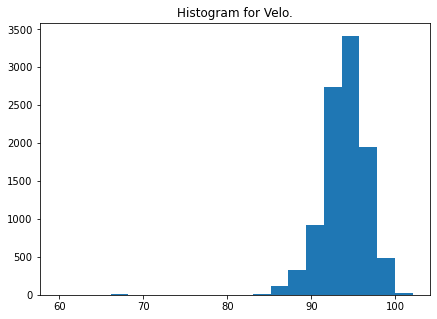

In [6]:
plot_histogram(train_df, 'Velo')

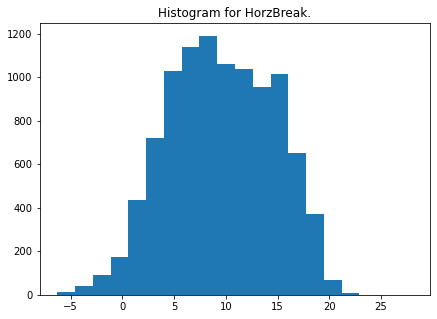

In [7]:
plot_histogram(train_df, 'HorzBreak')

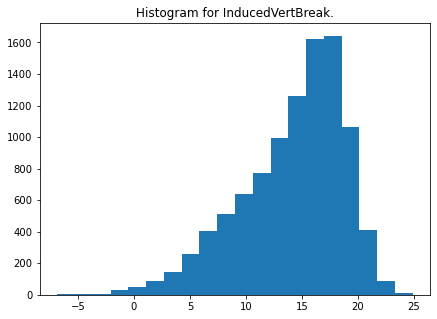

In [8]:
plot_histogram(train_df, 'InducedVertBreak')

- There does seem to be a couple outliers for Velocity. I will explore those.

In [9]:
train_df[train_df.Velo <= 75]

,InPlay,Velo,SpinRate,HorzBreak,InducedVertBreak
92,0,70.79,1504.0,8.99,15.17
142,0,67.61,1641.0,15.35,7.25
185,1,66.90,1629.0,13.55,14.67
2575,1,71.46,1796.0,6.82,15.94
3350,1,66.44,1391.0,-5.62,16.42
3685,0,59.76,1425.0,0.50,12.68
3949,0,72.33,1758.0,8.35,12.89
4127,1,72.91,1794.0,13.29,16.32
5153,0,62.61,1288.0,9.82,10.67
5442,1,61.17,1681.0,9.50,16.05


- Because there are multiple slow pitches for Pitcher A, I am not too concerned and will leave them in the dataset.

## Create Model to predict InPlay probability
- I will explore logistic regression and random forest

In [10]:
# get X and y dataframes
X = train_df[['Velo', 'SpinRate', 'HorzBreak', 'InducedVertBreak']]
y = train_df.InPlay

# create train test split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# initialize and fit Random Forest
rf = RandomForestClassifier(n_jobs=-1).fit(X_train, y_train)

# predict the probability
y_hat_prob = rf.predict_proba(X_test)

# get the log loss score
rf_log_loss = log_loss(y_test, y_hat_prob)

In [12]:
# initialize logistic regression
lr = LogisticRegression().fit(X_train, y_train)

# predict the probability
y_hat_prob = lr.predict_proba(X_test)

# get the log loss score
lr_log_loss = log_loss(y_test, y_hat_prob)

In [13]:
print('Log Loss for Logistic Regression:', round(lr_log_loss, 4))
print('Log Loss for Random Forest Classification:', round(rf_log_loss, 4))

Log Loss for Logistic Regression: 0.5741
Log Loss for Random Forest Classification: 0.598


- Logistic Regression is outpreforming the Rnadom Forest. That is what I will use for the final model.

## Train Final Model and Make Final Predictions

In [14]:
# read in data
test_df = pd.read_csv('deploy.csv')

# fill missing spin values with the average
test_df['SpinRate'] = test_df['SpinRate'].fillna(spin_avg)

In [15]:
# initialize logistic regression and train full model
lr = LogisticRegression().fit(X, y)

# predict the probability
y_hat_prob = lr.predict_proba(test_df)

# create the new column 
test_df['InPlay_probability'] = np.round(y_hat_prob[:, 1], 4)

In [16]:
# write to a csv
test_df.to_csv('deploy_with_predictions.csv', index=False)

### 2. In one paragraph, please explain your process and reasoning for any decisions you made in Question 1. 
For this assignment, we wanted to predict the probability of a ball being put into play based on the pitch’s velocity, spin rate, horizontal break, and vertical break. I explored the data first, as I wanted to check for missing values and outliers, and ended up finding a few missing values. Since there was not a large number of missing values, I decided to fill them with the mean, as that would not drastically alter my results. I looked at two different models, Logistic Regression and Random Forest Classifier. After fitting both, Logistic Regression had the lower log loss score on the test set, so that was the model I ended up going with. Finally, I fitted the full model and got the predictions for deploy.csv.

### 3. In one or two sentences, please describe to the pitcher how these 4 variables affect the batter’s ability to put the ball in play. You can also include one plot or table to show to the pitcher if you think it would help.

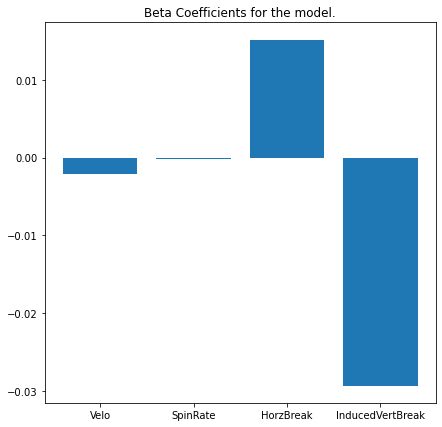

In [17]:
fig, ax = plt.subplots(figsize=(7,7))
labels = ['Velo', 'SpinRate', 'HorzBreak', 'InducedVertBreak']
values = lr.coef_
plt.bar(x=labels, height=values[0])
plt.title('Beta Coefficients for the model.')
plt.show()

When velocity and induced vertical break increase, the probability of it being put in play drops. When horizontal break increases, the probability increases.

### 4. In one of two sentences, please describe what you would see as the next steps with your model and/or results if you were in the analyst role and had another week to work on the question posed by the pitcher.
A potential next step would be to explore more types of models, maybe a neural network or adaboost. I would also like to have data about the pitch location and batter handedness.